# Kaggleで磨く 機械学習の実践力
# 第4章 ベースライン作成

# 4.3 ファイルの読み込み
#### スクリプト4-1: ライブラリの読み込み

In [1]:
# 2022/06/02追加: Kaggle notebook環境変更のため
!pip install pandas_profiling==3.2.0

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認
import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

/Users/mitsutaka/.pyenv/versions/anaconda3-2021.11/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 8.1 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=b9578b01d5248dd978775e3354aca00b66a6b591df5ac61ad8512adb5fa6618e
  Stored in directory: /Users/mitsutaka/Library/Caches/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib


#### スクリプト4-2: ファイルの読み込み

In [4]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 4.4 データの確認（簡易）
## 4.4.1 レコード数とカラム数の確認

#### スクリプト4-3: レコード数とカラム数の確認

In [5]:
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


## 4.4.2 カラムごとのデータの種類の確認

#### スクリプト4-4: データの確認

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### スクリプト4-5: データ型の変換

In [7]:
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


#### スクリプト4-6: データ型をobject型からint型に戻す

In [8]:
df_train["Pclass"] = df_train["Pclass"].astype(np.int64)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


## 4.4.3 欠損値の確認
#### スクリプト4-7: 欠損値の確認

In [9]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 4.5 データセット作成
#### スクリプト4-8: データセット作成

In [10]:
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


# 4.6 バリデーション設計
## 4.6.2 ホールドアウト検証と交差検証
#### スクリプト4-9: ホールドアウト検証の実行

In [11]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


#### スクリプト4-10: クロスバリデーションの実行

In [12]:
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))
for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),
        y_tr["Survived"].mean(),
        y_va["Survived"].mean(),
    ))
    
    # ここでモデル学習（ここは次節にて説明するため省略）

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


# 4.7 モデル学習（勾配ブースティング）
## 4.7.1 ホールドアウト検証の場合
#### スクリプト4-11: データセットの作成（スクリプト4-9の再掲）

In [13]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


#### スクリプト4-12: モデル学習（ホールドアウト検証の場合）

In [14]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr,y_tr), (x_va,y_va)],
          early_stopping_rounds=100,
          verbose=10,
         )

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc: 0.834593	valid_1's auc: 0.750132
[100]	training's auc: 0.837247	valid_1's auc: 0.747892
[110]	training's auc: 0.839036	valid_1's auc: 0.746838
[120]	training's auc: 0.840764	valid_1's auc: 0.746311
[130]	training's auc: 0.842007	valid_1's auc: 0.746706
Early stopping, best iteration is:
[35]	training's auc: 0.81342	valid_1's auc: 0.761265


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

#### スクリプト4-13: 精度の評価

In [15]:
y_tr_pred = model.predict_proba(x_tr)[:,1]
y_va_pred = model.predict_proba(x_va)[:,1]

metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5, 1, 0))
metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5, 1, 0))

print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))

[accuracy] tr: 0.75, va: 0.73


#### スクリプト4-14: 説明変数の重要度の算出

In [16]:
imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


## 4.7.2 クロスバリデーションの場合
#### スクリプト4-15: モデル学習の実行（クロスバリデーションの場合）

In [17]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
    
metrics = []
imp = pd.DataFrame()

n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),
        y_tr["Survived"].mean(),
        y_va["Survived"].mean(),
    ))
    
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr), (x_va,y_va)],
              early_stopping_rounds=100,
              verbose=100,
             )

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    
    metrics.append([nfold, metric_tr, metric_va])
    
    _imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_, "nfold":nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print("-"*20, "result", "-"*20)
metrics = np.array(metrics)
print(metrics)

print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)

print("Done.")

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
Early stopping, best iteration is:
[12]	training's auc: 0.793779	valid_1's auc: 0.740382
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.826717	valid_1's auc: 0.753008
Early stopping, best iteration is:
[26]	training's auc: 0.807006	valid_1's auc: 0.757219
[accuracy] tr: 0.75, va: 0.68
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.839483	valid_1's auc: 0.732687
[200]	training's auc: 0.849542	valid_1's auc: 0.737233
Ea

#### スクリプト4-16: 説明変数の重要度の算出

In [18]:
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


## 4.7.3 ベースラインの評価
#### スクリプト4-17: ベースライン検証用データの作成

In [19]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_train,
                                            random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


#### スクリプト4-18: 学習データと検証データの分割（ホールドアウト検証）

In [20]:
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


#### スクリプト4-19: モデル学習（ホールドアウト検証）

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1), (x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[20]	training's auc: 0.810025	valid_1's auc: 0.712087
[30]	training's auc: 0.822545	valid_1's auc: 0.72376
[40]	training's auc: 0.829204	valid_1's auc: 0.719421
[50]	training's auc: 0.836699	valid_1's auc: 0.720455
[60]	training's auc: 0.841808	valid_1's auc: 0.716322
[70]	training's auc: 0.84684	valid_1's auc: 0.71281
[80]	training's auc: 0.851009	valid_1's auc: 0.716529
[90]	training's auc: 0.85472	valid_1's auc: 0.720041
[100]	training's auc: 0.856354	valid_1's auc: 0.722934
Early stopping, best iteration is:
[7]	training's auc: 0.787396	valid_1's auc: 0.729545


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

#### スクリプト4-20: 検証データとベースライン検証用データの予測値算出

In [ ]:
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

: 

#### スクリプト4-21: モデル精度の比較

In [ ]:
print("[検証データ] acc: {:.4f}".format(accuracy_score(y_va1, y_va1_pred)))
print("[ベースライン検証用データ] acc: {:.4f}".format(accuracy_score(y_va2, y_va2_pred)))

: 

#### スクリプト4-22: 誤差分布の比較

In [ ]:
print("検証データ")
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))
print("ベースライン検証用データ")
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))

: 

#### スクリプト4-23: 予測値の分布比較

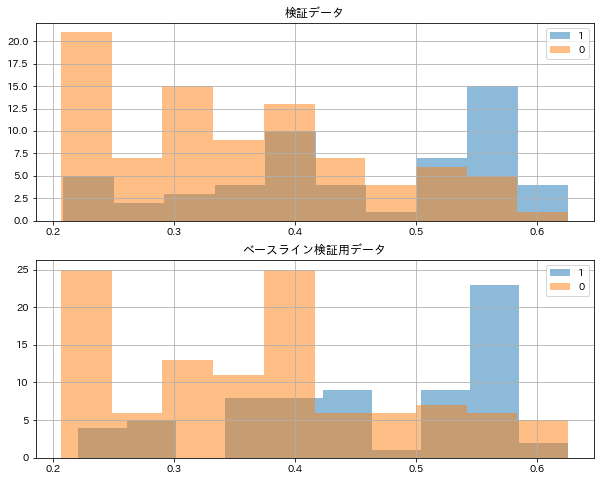

In [22]:
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2,1,1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証用データ
fig.add_subplot(2,1,2)
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

# 4.8 モデル推論
## 4.8.1 推論データセット作成
#### スクリプト4-24: 推論用データセットの作成

In [23]:
df_test = pd.read_csv("../input/titanic/test.csv")
x_test = df_test[["Pclass", "Fare"]]
id_test = df_test[["PassengerId"]]

## 4.8.2 学習済モデルを用いた推論
#### スクリプト4-25: 学習モデルによる推論

In [24]:
y_test_pred = model.predict(x_test)

#### スクリプト4-26: 提出用ファイルの作成

In [25]:
df_submit = pd.DataFrame({"PassengerId":id_test["PassengerId"], "Survived":y_test_pred})
display(df_submit.head(5))
df_submit.to_csv("submission_baseline.csv", index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
